In [2]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import copy
import json

task = "flatpack"
num_models = 1
sweep_specifier = "arxiv"
max_round_num = 2700
linewidth = 3

llama32best = "s2"
qwensmallbest = "s0"
granitebest = "s2"
phibest = "s2"
prefix = "finalarxiv"
model_names = ["llama32"
                # , "qwensmall"
                , "granite"
                , "phi"]
model_name = "llama32"
seed = 0

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')

legend_name_map = {
    # "qwensmall-s0": "Qwen - EvoTune",
    # "qwensmall-b": "Qwen - FunSearch",
    "llama32-s2": "Llama - EvoTune",
    "llama32-b": "Llama - FunSearch",
    "granite-s2": "Granite - EvoTune",
    "granite-b": "Granite - FunSearch",
    "phi-s2": "Phi - EvoTune",
    "phi-b": "Phi - FunSearch",
}


color_map = {
    "llama32":   "#76B7B2",  # Blue "#76B7B2"
    "phi":       "#F28E2B",  # Orange
    "granite":   "#E15759",  # Red
    "qwensmall": "#4E79A7",  # Teal
}


font_family = 'Times New Roman'  # Change to desired font

line_style_map = {
    "b": "dotted",
    "s0": "solid",
    "s2": "solid",
}

In [5]:
import pickle
# with open(f"all_histograms_averaged.pkl", "rb") as f:
#     all_histograms_averaged = pickle.load(f)
with open(f"files/all_histograms_averaged.pkl", "rb") as f:
    all_histograms_averaged = pickle.load(f)
# with open(f"all_histograms_averaged_30.pkl", "rb") as f:
#     all_histograms_averaged = pickle.load(f)

In [6]:
# color_pairs
# 1.	Cobalt Blue + Orange
# main_color, baseline_color = '#0047AB', '#FFA500'

# 2.	Navy Blue + Bright Yellow
# main_color, baseline_color = '#000080', '#FFFF00'

# 3.	Turquoise + Red
# main_color, baseline_color = '#40E0D0', '#FF0000'

# 4.	Sky Blue + Dark Gray
# main_color, baseline_color = '#87CEEB', '#333333'

# 5.	Pink + Deep Green
# main_color, baseline_color = '#FF69B4', '#006400'

# 6.	Electric Blue + Yellow-Green
# main_color, baseline_color = '#00FFFF', '#9ACD32'

# 7.	Magenta + Lime Green
# main_color, baseline_color = '#FF00FF', '#00FF00'

# 8.	Bright Purple + Tangerine
# main_color, baseline_color = '#800080', '#FF6347'

# 9.	Crimson + Cyan
# main_color, baseline_color = '#DC143C', '#00FFFF'

# 10.	Goldenrod + Slate Blue
# main_color, baseline_color = '#DAA520', '#6A5ACD'

# 11.	Deep Pink + Light Green
# main_color, baseline_color = '#1f77b4', '#ff7f0e'
main_color, baseline_color = "#0047AB", "red"

# 12. Soft Blue + Red
# main_color, baseline_color = "#1f77b4", "red"


In [15]:
task = "flatpack"
num_models = 1
sweep_specifier = "arxiv"
max_round_num = 2700
linewidth = 3

llama32best = "s2"
qwensmallbest = "s0"
granitebest = "s2"
phibest = "s2"
prefix = "finalarxiv"
model_names = ["llama32"
                # , "qwensmall"
                , "granite"
                , "phi"]
model_name = "llama32"
seed = 0

SCRATCH_PATH = '../../out/anja'

all_histograms_averaged = {key: {} for key in ["bin", "tsp"]}

for task in ["flatpack"]:
    all_histograms_averaged[task] = {key: {} for key in model_names}
    for model_name in model_names:
        scores = {}
        scores_baseline = {}
        for seed in range(10):
            scores[seed] = {}
            scores_baseline[seed] = {}

            sweep_identifier = "s2"
            path = f"{SCRATCH_PATH}/{task}_task{task}_{num_models}m{model_name}arxiv{sweep_identifier}_{seed}/programdb_scores.json"

            with open(path) as f:
                pdb_scores = json.load(f)

            for pair in pdb_scores:
                round_num, scores_ = pair.values()
                scores_ = [s for s in scores_ if s > -40]
                scores[seed][round_num] = np.array(scores_)
            rounds = list(scores[0].keys())

            sweep_identifier = "b"
            path = f"{SCRATCH_PATH}/{task}_task{task}_{num_models}m{model_name}arxiv{sweep_identifier}_{seed}/programdb_scores.json"

            with open(path) as f:
                pdb_scores = json.load(f)
            for pair in pdb_scores:
                round_num, scores_ = pair.values()
                scores_ = [s for s in scores_ if s > -40]
                scores_baseline[seed][round_num] = np.array(scores_)

        rounds.sort()
        rounds = rounds[:max_round_num]
        for round_num in rounds:
            # print(f"Processing {task} task, {model_name} model, round {round_num}...")
            all_seeds_scores_main = [scores[seed][round_num] for seed in scores if round_num in scores[seed]]
            all_seeds_scores_baseline = [scores_baseline[seed][round_num] for seed in scores_baseline if round_num in scores_baseline[seed]]

            # Get min/max score range across all seeds
            # all_scores_flat = np.concatenate(all_seeds_scores)
            all_scores_flat = np.concatenate(all_seeds_scores_main + all_seeds_scores_baseline)
            min_score, max_score = np.min(all_scores_flat), np.max(all_scores_flat)

            # Define bin edges
            num_bins = 20
            bins = np.linspace(min_score, max_score, num_bins + 1)

            # Compute histogram counts for each seed in both datasets
            histograms_main = np.array([np.histogram(seed_scores, bins=bins)[0] for seed_scores in all_seeds_scores_main])
            histograms_baseline = np.array([np.histogram(seed_scores, bins=bins)[0] for seed_scores in all_seeds_scores_baseline])

            # Compute mean and stderr of frequencies
            mean_freq_main = np.mean(histograms_main, axis=0)
            stderr_freq_main = np.std(histograms_main, axis=0) / np.sqrt(len(all_seeds_scores_main))

            mean_freq_baseline = np.mean(histograms_baseline, axis=0)
            stderr_freq_baseline = np.std(histograms_baseline, axis=0) / np.sqrt(len(all_seeds_scores_baseline))

            bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers for plotting

            all_histograms_averaged[task][model_name][round_num] = {
                "mean_freq_main": mean_freq_main,
                "stderr_freq_main": stderr_freq_main,
                "mean_freq_baseline": mean_freq_baseline,
                "stderr_freq_baseline": stderr_freq_baseline,
                "bin_centers": bin_centers,
                "bins": bins,
            }

import pickle
with open(f"files/all_histograms_averaged.pkl", "wb") as f:
    pickle.dump(all_histograms_averaged, f)

In [4]:
import pickle
with open(f"files/all_histograms_averaged.pkl", "rb") as f:
    all_histograms_averaged = pickle.load(f)

In [ ]:
# trained and baseline on the same plot across rounds, averaged across seeds
font_ticks = 36
font_axis = 36

task = "bin"
model_name = "phi"
sweep_identifier = "s2" # "b"

def scale_formatter(x, pos):
    return f"{x/100:.1f}"


for round_num in [100, 1100, 1900, 2700]:

    plt.figure(figsize=(16, 10))
    mean_freq_baseline = all_histograms_averaged[task][model_name][round_num]["mean_freq_baseline"]
    stderr_freq_baseline = all_histograms_averaged[task][model_name][round_num]["stderr_freq_baseline"]
    mean_freq_main = all_histograms_averaged[task][model_name][round_num]["mean_freq_main"]
    stderr_freq_main = all_histograms_averaged[task][model_name][round_num]["stderr_freq_main"]
    bin_centers = all_histograms_averaged[task][model_name][round_num]["bin_centers"]
    bins = all_histograms_averaged[task][model_name][round_num]["bins"]

    # Baseline model as step plot
    plt.step(bin_centers, mean_freq_baseline, where='mid',
            color=baseline_color, linestyle='dashed', linewidth=2, label=legend_name_map.get(f"{model_name}-b", "Baseline"))
    plt.errorbar(bin_centers, mean_freq_baseline, yerr=stderr_freq_baseline, fmt='s',
                color=baseline_color, capsize=3, markersize=4, markerfacecolor='white')

    # Main model histogram
    plt.bar(bin_centers, mean_freq_main, width=(bins[1] - bins[0]),
            color=main_color, alpha=0.6, edgecolor='black', label=legend_name_map.get(f"{model_name}-s2", "Main"))
    plt.errorbar(bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o',
                color=main_color, capsize=3, markersize=4, markerfacecolor='white')



    # # Improve ticks and grid
    plt.tick_params(axis="both", which="major", labelsize=font_ticks)
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily(font_family)

    legend = ax.legend(
    loc='upper left',         # place it above the plot
    # bbox_to_anchor=(0.5, 1.20), # adjust the y-value to move legend up/down
    ncol=1,                     # number of columns in the legend
    fontsize=font_ticks,
    frameon=True,
    handlelength=1.1,
    )
    #legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
    legend.get_frame().set_edgecolor("grey")  # Set frame color
    legend.get_frame().set_alpha(0.9)  # Set legend transparency
    for text in legend.get_texts():
        text.set_fontfamily(font_family)

    # Labels and legend
    plt.xlabel("Score", fontsize=font_axis, fontfamily=font_family)
    plt.ylabel("Average Frequency", fontsize=font_axis, fontfamily=font_family)

    plt.title(f"Histogram for Round {round_num}", fontsize=font_axis, fontfamily=font_family)
    # plt.legend()
    # plt.grid(True, linestyle="--", alpha=0.8)
    plt.show()

# plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
# plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")


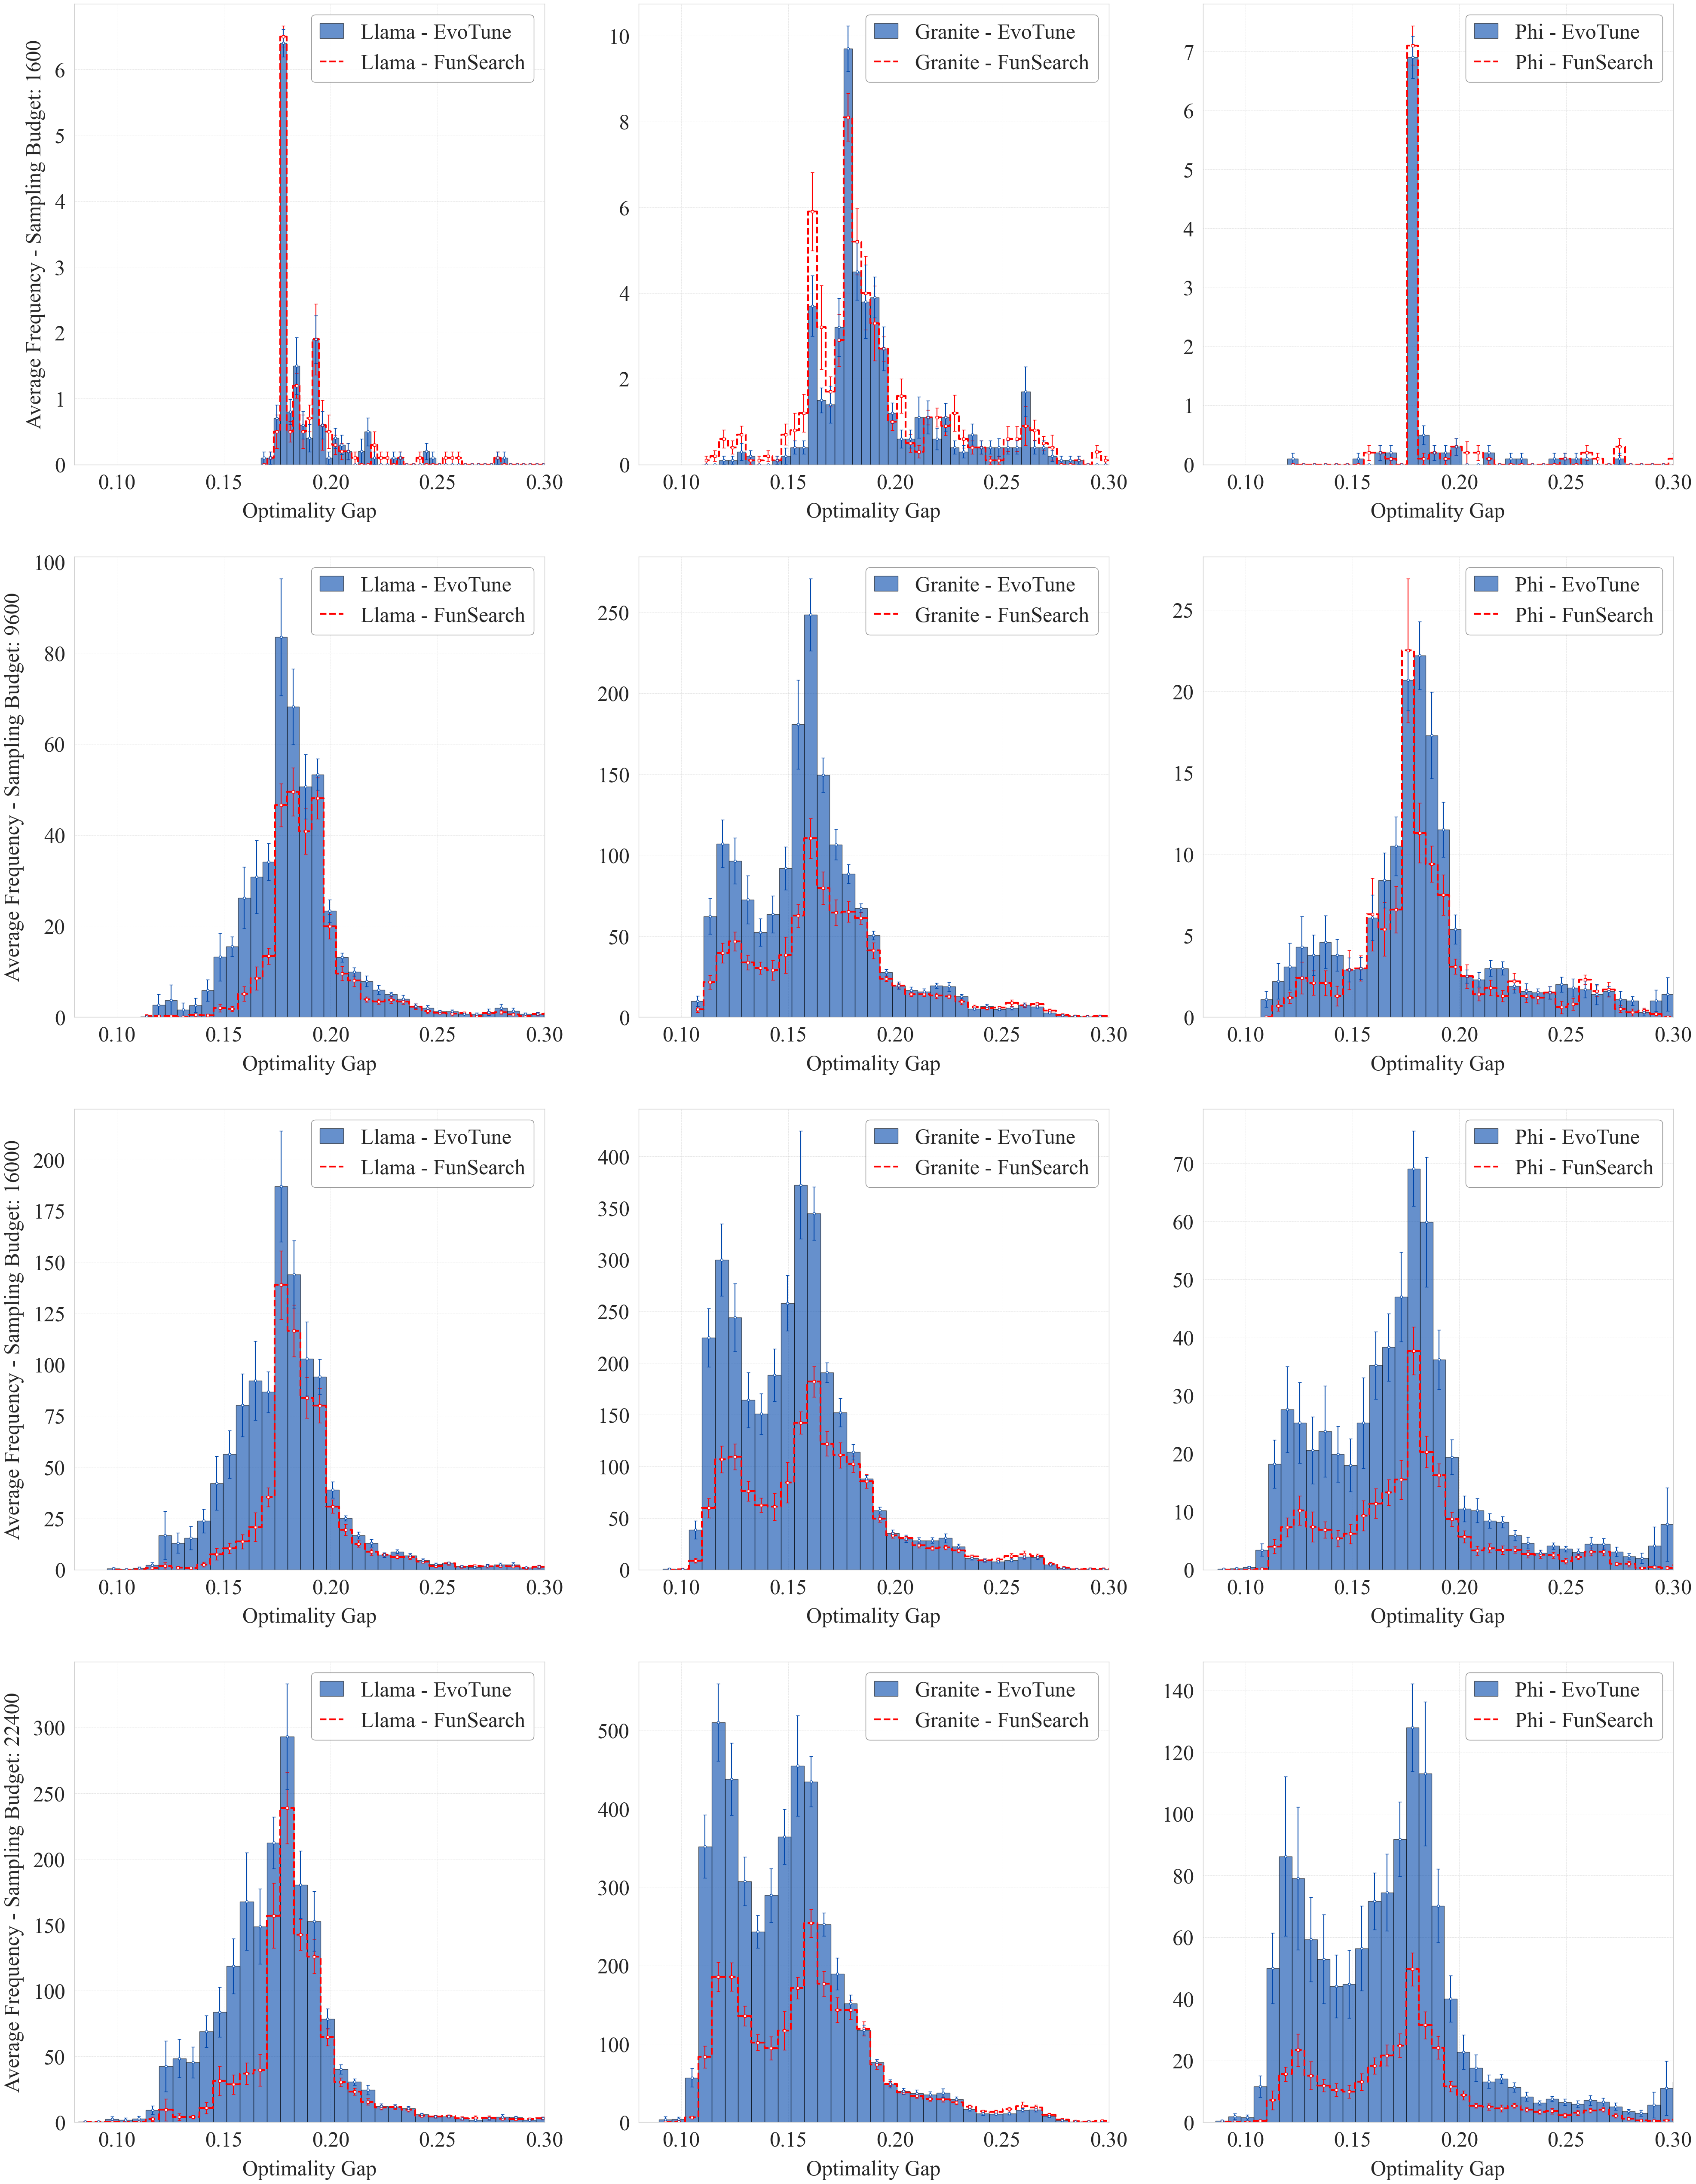

In [52]:
# create a 4x3 grid of plots, 4 rows for round nums, 3 columns for models

# trained and baseline on the same plot across rounds, averaged across seeds
figname = "pdb_dist"
font_ticks = 36
font_axis = 36
labelpad = 15
task = "bin"
fig_width = 48
fig_height = 64
# round_num_to_budget = {100: "1.6", 1100: "9.6", 1900: "16k", 2700: "22.4k"}
round_num_to_budget = {100: "1600", 1100: "9600", 1900: "16000", 2700: "22400"}

def scale_formatter(x, pos):
    return f"{x/100:.2f}"

for task in ["flatpack"]:
    fig, axs = plt.subplots(4, 3, figsize=(fig_width, fig_height))

    for i, round_num in enumerate([100, 1100, 1900, 2700]):
        for j, model_name in enumerate(model_names):
            mean_freq_baseline = all_histograms_averaged[task][model_name][round_num]["mean_freq_baseline"]
            stderr_freq_baseline = all_histograms_averaged[task][model_name][round_num]["stderr_freq_baseline"]
            mean_freq_main = all_histograms_averaged[task][model_name][round_num]["mean_freq_main"]
            stderr_freq_main = all_histograms_averaged[task][model_name][round_num]["stderr_freq_main"]
            bin_centers = all_histograms_averaged[task][model_name][round_num]["bin_centers"]
            bins = all_histograms_averaged[task][model_name][round_num]["bins"]

            bin_centers_ = all_histograms_averaged[task][model_names[j]][100]["bin_centers"]
            min_score = np.min([np.min(bin_centers_), np.min(bin_centers_)])
            bin_centers_ = all_histograms_averaged[task][model_names[j]][2700]["bin_centers"]
            max_score = np.max([np.max(bin_centers_), np.max(bin_centers_)])

            # Baseline model as step plot
            axs[i,j].step(-bin_centers, mean_freq_baseline, where='mid',
                    color=baseline_color, linestyle='dashed', linewidth=3, label=legend_name_map.get(f"{model_name}-b", "Baseline"))
            axs[i,j].errorbar(-bin_centers, mean_freq_baseline, yerr=stderr_freq_baseline, fmt='s',
                        color=baseline_color, capsize=3, markersize=4, markerfacecolor='white')

            # Main model histogram
            axs[i,j].bar(-bin_centers, mean_freq_main, width=(bins[1] - bins[0]),
                    color=main_color, alpha=0.6, edgecolor='black', label=legend_name_map.get(f"{model_name}-s2", "Main"))
            axs[i,j].errorbar(-bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o',
                        color=main_color, capsize=3, markersize=4, markerfacecolor='white')



            # # Improve ticks and grid
            axs[i,j].tick_params(axis="both", which="major", labelsize=font_ticks, pad=15)
            axs[i,j].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            axs[i,j].xaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))
            for label in axs[i,j].get_xticklabels() + axs[i,j].get_yticklabels():
                label.set_fontfamily(font_family)
            if task == "bin":
                # axs[i,j].set_xlim(-(min_score-50), -(max_score+50))
                axs[i,j].set_xlim(-(max_score+50), -(min_score))
            elif task == "flatpack":
                axs[i,j].set_xlim(8, 30)
            else:
                # axs[i,j].set_xlim(-(min_score-10), -(max_score+10))
                axs[i,j].set_xlim(-(max_score+10), -(min_score-10))

            # legend = axs[i,j].legend(
            # loc='upper left',         # place it above the plot
            # # bbox_to_anchor=(0.5, 1.20), # adjust the y-value to move legend up/down
            # ncol=1,                     # number of columns in the legend
            # fontsize=font_ticks,
            # frameon=True, 
            # handlelength=1.1,        
            # )
            handles, labels = axs[i,j].get_legend_handles_labels()
            legend = axs[i,j].legend(
                handles[::-1], labels[::-1],  # Reverse the order
                loc='upper right',
                ncol=1,
                fontsize=font_ticks,
                frameon=True,
                handlelength=1.1,
            )
            #legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
            legend.get_frame().set_edgecolor("grey")  # Set frame color
            legend.get_frame().set_alpha(0.9)  # Set legend transparency
            for text in legend.get_texts():
                text.set_fontfamily(font_family)

            # Labels and legend
            # if i == 3:
            # axs[i,j].set_xlabel("Score", fontsize=font_axis, fontfamily=font_family)
            axs[i,j].set_xlabel("Optimality Gap", fontsize=font_axis, fontfamily=font_family, labelpad=labelpad)
            if j == 0:
                axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: {round_num_to_budget[round_num]}", fontsize=font_axis, fontfamily=font_family, labelpad=labelpad)
                # if i == 0:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>1600</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 1:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>9600</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 2:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>16000</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 3:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>22400</b>", fontsize=font_axis, fontfamily=font_family)
            # if i == 0:
            #     axs[i,j].set_title(f"Function-Sampling Budget: {round_num_to_budget[round_num]}", fontsize=font_axis, fontfamily=font_family)
            # plt.legend()
            # plt.grid(True, linestyle="--", alpha=0.8)
    # plt.show()
    plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")



In [ ]:
# create a 4x3 grid of plots, 4 rows for round nums, 3 columns for models
import matplotlib.ticker as ticker
# trained and baseline on the same plot across rounds, averaged across seeds
figname = "pdb_dist_example"
font_ticks = 36
font_axis = 36
tasks = ["tsp"]
labelpad=15
fig_width = 24
fig_height = 12
# round_num_to_budget = {100: "1.6", 1100: "9.6", 1900: "16k", 2700: "22.4k"}
round_num_to_budget = {100: "1600", 1100: "9600", 1900: "16000", 2700: "22400"}

def scale_formatter(x, pos):
    return f"{x/100:.1f}"

for task in tasks:
    fig, axs = plt.subplots(1, 2, figsize=(fig_width, fig_height))

    for i, model_name in enumerate(["phi"]):
        for j, round_num in enumerate([100, 2700]):
            mean_freq_baseline = all_histograms_averaged[task][model_name][round_num]["mean_freq_baseline"]
            stderr_freq_baseline = all_histograms_averaged[task][model_name][round_num]["stderr_freq_baseline"]
            mean_freq_main = all_histograms_averaged[task][model_name][round_num]["mean_freq_main"]
            stderr_freq_main = all_histograms_averaged[task][model_name][round_num]["stderr_freq_main"]
            bin_centers = all_histograms_averaged[task][model_name][round_num]["bin_centers"]
            bins = all_histograms_averaged[task][model_name][round_num]["bins"]

            min_score = 0.
            max_score = -1000.
            for round_num_ in [100, 1100, 1900, 2700]:
                bin_centers_ = all_histograms_averaged[task][model_names[j]][round_num_]["bin_centers"]
                min_score = np.min([np.min(bin_centers_), np.min(bin_centers_), min_score])
                max_score = np.max([np.max(bin_centers_), np.max(bin_centers_), max_score])

            # Main model histogram
            axs[j].bar(-bin_centers, mean_freq_main, width=(bins[1] - bins[0]),
                    color=main_color, alpha=0.6, edgecolor='black', label=legend_name_map.get(f"{model_name}-s2", "Main"))
            axs[j].errorbar(-bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o',
                        color=main_color, capsize=3, markersize=4, markerfacecolor='white')

            # Baseline model as step plot
            axs[j].step(-bin_centers, mean_freq_baseline, where='mid',
                    color=baseline_color, linestyle='dashed', linewidth=3, label=legend_name_map.get(f"{model_name}-b", "Baseline"))
            axs[j].errorbar(-bin_centers, mean_freq_baseline, yerr=stderr_freq_baseline, fmt='s',
                        color=baseline_color, capsize=3, markersize=4, markerfacecolor='white')


            # # Improve ticks and grid
            axs[j].tick_params(axis="both", which="major", labelsize=font_ticks, pad=15)
            axs[j].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            # axs[j].xaxis.set_major_locator(ticker.MultipleLocator(100))
            # print(min_score, max_score)
            # axs[j].set_xlim((min_score-50), (max_score+50))
            axs[j].set_xlim(-(max_score+50), -(min_score))
            for label in axs[j].get_xticklabels() + axs[j].get_yticklabels():
                label.set_fontfamily(font_family)
            axs[j].xaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))

            # legend = axs[j].legend(
            # loc='upper left',         # place it above the plot
            # # bbox_to_anchor=(0.5, 1.20), # adjust the y-value to move legend up/down
            # ncol=1,                     # number of columns in the legend
            # fontsize=font_ticks,
            # frameon=True, 
            # handlelength=1.1,        
            # )
            handles, labels = axs[j].get_legend_handles_labels()
            legend = axs[j].legend(
                handles[::-1], labels[::-1],  # Reverse the order
                loc='upper right',
                ncol=1,
                fontsize=font_ticks-4,
                frameon=True,
                handlelength=1.1,
            )

            #legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
            legend.get_frame().set_edgecolor("grey")  # Set frame color
            legend.get_frame().set_alpha(0.9)  # Set legend transparency
            for text in legend.get_texts():
                text.set_fontfamily(font_family)

            # Labels and legend
            # if i == 3:
            axs[j].set_xlabel("Optimality Gap", fontsize=font_axis, fontfamily=font_family)
            if j == 0:
                axs[j].set_ylabel(rf"Average Frequency", fontsize=font_axis, fontfamily=font_family, labelpad=labelpad)
                # if i == 0:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>1600</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 1:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>9600</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 2:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>16000</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 3:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>22400</b>", fontsize=font_axis, fontfamily=font_family)
            # if i == 0:
            axs[j].set_title(f"Program-Sampling Budget: {round_num_to_budget[round_num]}", fontsize=font_axis, fontfamily=font_family, pad=labelpad)
            # plt.legend()
            # plt.grid(True, linestyle="--", alpha=0.8)
    # plt.show()
    plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")



In [17]:
import pickle
with open(f"files/all_histograms_averaged_20.pkl", "rb") as f:
    all_histograms_averaged_tmp = pickle.load(f)
all_histograms_averaged["tsp"] = all_histograms_averaged_tmp["tsp"]
all_histograms_averaged["bin"] = all_histograms_averaged_tmp["bin"]

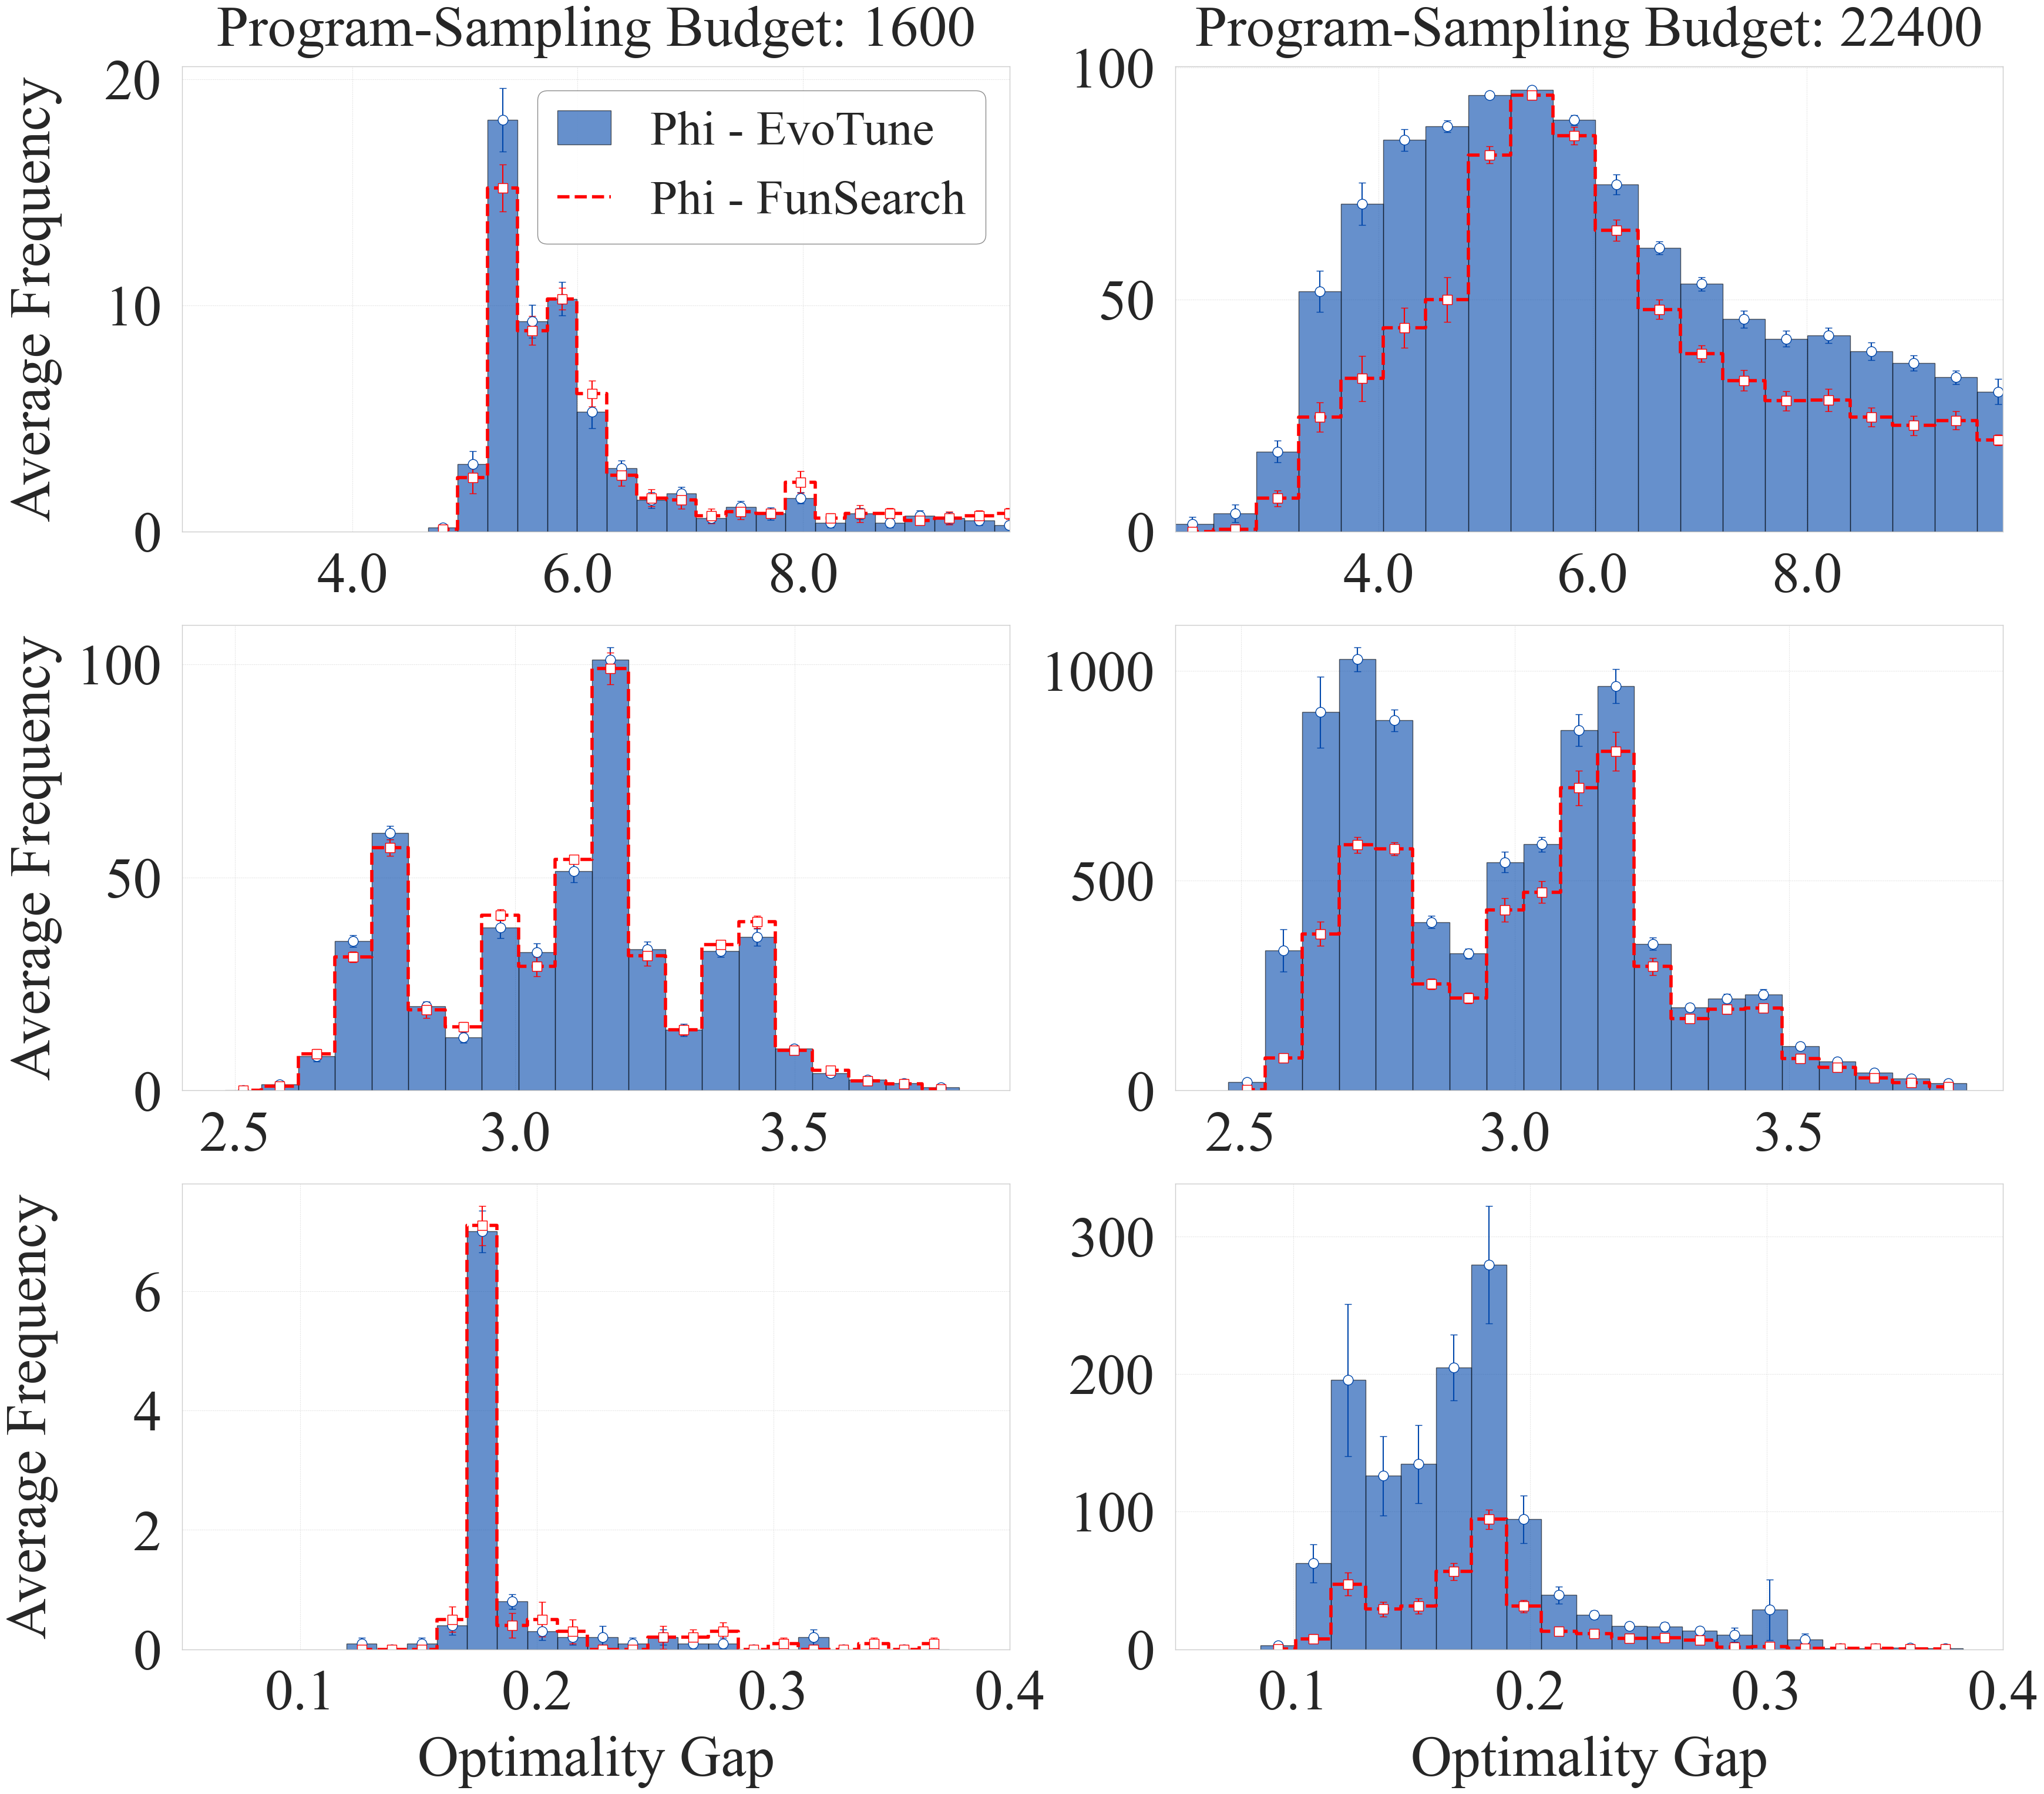

In [19]:
# create a 4x3 grid of plots, 4 rows for round nums, 3 columns for models
import matplotlib.ticker as ticker
# trained and baseline on the same plot across rounds, averaged across seeds
figname = "pdb_dist_example_bintspflatpack_3x2"
font_ticks = 70
font_axis = 70
tasks = ["bin","tsp", "flatpack"]
labelpad = 17
fig_width = 40
fig_height = 35
# round_num_to_budget = {100: "1.6", 1100: "9.6", 1900: "16k", 2700: "22.4k"}
round_num_to_budget = {100: "1600", 1100: "9600", 1900: "16000", 2700: "22400"}

def scale_formatter(x, pos):
    return f"{x/100:.1f}"

fig, axs = plt.subplots(3, 2, figsize=(fig_width, fig_height))
for i, task in enumerate(tasks):
    for _, model_name in enumerate(["phi"]):
        for j, round_num in enumerate([100, 2700]):
            mean_freq_baseline = all_histograms_averaged[task][model_name][round_num]["mean_freq_baseline"]
            stderr_freq_baseline = all_histograms_averaged[task][model_name][round_num]["stderr_freq_baseline"]
            mean_freq_main = all_histograms_averaged[task][model_name][round_num]["mean_freq_main"]
            stderr_freq_main = all_histograms_averaged[task][model_name][round_num]["stderr_freq_main"]
            bin_centers = all_histograms_averaged[task][model_name][round_num]["bin_centers"]
            bins = all_histograms_averaged[task][model_name][round_num]["bins"]

            min_score = 0.
            max_score = -1000.
            for round_num_ in [100, 1100, 1900, 2700]:
                bin_centers_ = all_histograms_averaged[task][model_names[j]][round_num_]["bin_centers"]
                min_score = np.min([np.min(bin_centers_), np.min(bin_centers_), min_score])
                max_score = np.max([np.max(bin_centers_), np.max(bin_centers_), max_score])

            # Main model histogram
            axs[i,j].bar(-bin_centers, mean_freq_main, width=(bins[1] - bins[0]),
                    color=main_color, alpha=0.6, edgecolor='black', label=legend_name_map.get(f"{model_name}-s2", "Main"))
            axs[i,j].errorbar(-bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o',
                        color=main_color, capsize=4, markersize=12, markerfacecolor='white')

            # Baseline model as step plot
            axs[i,j].step(-bin_centers, mean_freq_baseline, where='mid',
                    color=baseline_color, linestyle='dashed', linewidth=4, label=legend_name_map.get(f"{model_name}-b", "Baseline"))
            axs[i,j].errorbar(-bin_centers, mean_freq_baseline, yerr=stderr_freq_baseline, fmt='s',
                        color=baseline_color, capsize=4, markersize=12, markerfacecolor='white')


            # # Improve ticks and grid
            axs[i,j].tick_params(axis="both", which="major", labelsize=font_ticks, pad=25)
            axs[i,j].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            # axs[j].xaxis.set_major_locator(ticker.MultipleLocator(100))
            # print(min_score, max_score)
            # axs[j].set_xlim((min_score-50), (max_score+50))
            if task == "bin":
                axs[i,j].set_xlim(-(max_score+50), -(min_score))
            elif task == "flatpack":
                axs[i,j].set_xlim(5, 40)
            else:
                axs[i,j].set_xlim(-(max_score+10), -(min_score-10))
            for label in axs[i,j].get_xticklabels() + axs[i,j].get_yticklabels():
                label.set_fontfamily(font_family)
            axs[i,j].xaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))

            # legend = axs[j].legend(
            # loc='upper left',         # place it above the plot
            # # bbox_to_anchor=(0.5, 1.20), # adjust the y-value to move legend up/down
            # ncol=1,                     # number of columns in the legend
            # fontsize=font_ticks,
            # frameon=True, 
            # handlelength=1.1,        
            # )
            handles, labels = axs[i,j].get_legend_handles_labels()
            if i == 0 and j == 0:
                legend = axs[i,j].legend(
                    handles[::-1], labels[::-1],  # Reverse the order
                    loc='upper right',
                    ncol=1,
                    fontsize=font_ticks-10,
                    frameon=True,
                    handlelength=1.1,
                )

            #legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
            legend.get_frame().set_edgecolor("grey")  # Set frame color
            legend.get_frame().set_alpha(0.9)  # Set legend transparency
            for text in legend.get_texts():
                text.set_fontfamily(font_family)

            # Labels and legend
            if i == 2:
                axs[i,j].set_xlabel("Optimality Gap", fontsize=font_axis, fontfamily=font_family, labelpad=labelpad)
            if j == 0:
                if i == 0:
                    axs[i,j].set_ylabel(rf"Average Frequency", fontsize=font_axis, fontfamily=font_family, labelpad=labelpad+35)
                elif i == 2:
                    axs[i,j].set_ylabel("Average Frequency", fontsize=font_axis, fontfamily=font_family, labelpad=labelpad+75)
                else:
                    axs[i,j].set_ylabel(rf"Average Frequency", fontsize=font_axis, fontfamily=font_family, labelpad=labelpad)
                # if i == 0:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>1600</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 1:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>9600</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 2:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>16000</b>", fontsize=font_axis, fontfamily=font_family)
                # if i == 3:
                #     axs[i,j].set_ylabel(rf"Average Frequency - Sampling Budget: <b>22400</b>", fontsize=font_axis, fontfamily=font_family)
            # if i == 0:
            if i == 0:
                axs[i,j].set_title(f"Program-Sampling Budget: {round_num_to_budget[round_num]}", fontsize=font_axis, fontfamily=font_family, pad=25)
            # plt.legend()
            # plt.grid(True, linestyle="--", alpha=0.8)
    # plt.show()

# Get current positions
pos1 = axs[0,0].get_position()
pos2 = axs[0,1].get_position()
pos3 = axs[1,0].get_position()
pos4 = axs[1,1].get_position()
pos5 = axs[1,0].get_position()
pos6 = axs[1,1].get_position()

# increase the vertical spacing between subplots at [0, 0] and [1, 0] as well as [0, 1] and [1, 1]
d = 0.1
pos1.y0 -= d
pos1.y1 -= d
pos3.y0 -= d
pos3.y1 -= d
pos5.y0 -= d
pos5.y1 -= d

plt.savefig(f"files/{figname}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"files/{figname}.pdf", dpi=300, bbox_inches="tight")



### Step Histogram (EvoTune vs. Funsearch) - one model across different rounds

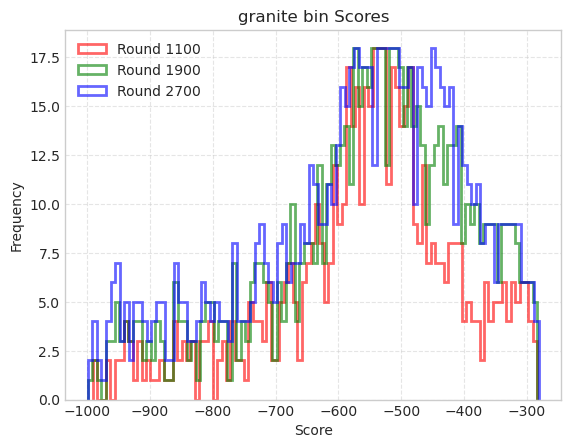

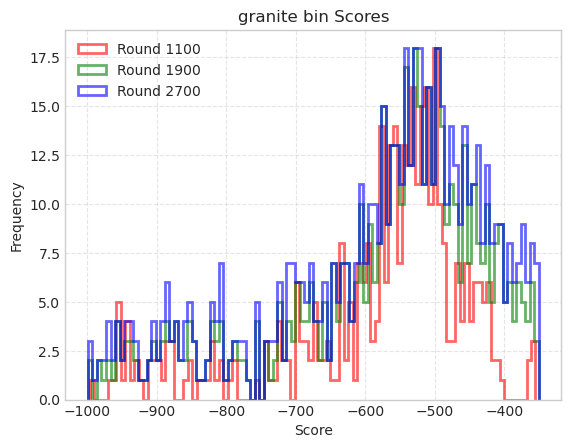

In [43]:
task = "bin"
# one model across different rounds
model_name = "granite"
seed = 0
sweep_identifier = "s2" # "b"
path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"

with open(path) as f:
    pdb_scores = json.load(f)

scores = {}
for pair in pdb_scores:
    round_num, scores_ = pair.values()
    scores_ = [s for s in scores_ if s > -1000]
    scores[round_num] = np.array(scores_)


# plot the histograms of the scores across the rounds on the same plot, plot every 1000 rounds and on the same plot, use different colors for each round
round_list = [1100, 1900, 2700]
colors = ["red", "blue", "green"]
rounds = list(scores.keys())
rounds.sort()
rounds = rounds[:max_round_num]
for i, round_num in enumerate(rounds):
    if round_num not in round_list:
        continue
    scores_ = scores[round_num]
    plt.hist(scores_, bins=100, alpha=0.6, label=f"Round {round_num}",
             histtype="step", linewidth=2, color=colors[i % len(colors)])

plt.legend()
plt.title(f"{model_name} {task} Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)  # Add a subtle grid
plt.show()
#     scores_ = scores[round_num]
#     plt.hist(scores_, bins=100, alpha=0.5, label=f"Round {round_num}")#, color=color_map[model_name], linewidth=linewidth)
# plt.legend()
# plt.title(f"{model_name} {task} scores")
# plt.xlabel("Score")
# plt.ylabel("Frequency")
# plt.show()


sweep_identifier = "b"
path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"

with open(path) as f:
    pdb_scores = json.load(f)

scores = {}
for pair in pdb_scores:
    round_num, scores_ = pair.values()
    scores_ = [s for s in scores_ if s > -1000]
    scores[round_num] = np.array(scores_)


# plot the histograms of the scores across the rounds on the same plot, plot every 1000 rounds and on the same plot, use different colors for each round
round_list = [1100, 1900, 2700]
colors = ["red", "blue", "green"]
rounds = list(scores.keys())
rounds.sort()
rounds = rounds[:max_round_num]
for i, round_num in enumerate(rounds):
    if round_num not in round_list:
        continue
    scores_ = scores[round_num]
    plt.hist(scores_, bins=100, alpha=0.6, label=f"Round {round_num}",
             histtype="step", linewidth=2, color=colors[i % len(colors)])

plt.legend()
plt.title(f"{model_name} {task} Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)  # Add a subtle grid
plt.show()
#     scores_ = scores[round_num]
#     plt.hist(scores_, bins=100, alpha=0.5, label=f"Round {round_num}")#, color=color_map[model_name], linewidth=linewidth)
# plt.legend()
# plt.title(f"{model_name} {task} scores")
# plt.xlabel("Score")
# plt.ylabel("Frequency")
# plt.show()

### Step Histogram (EvoTune vs. Funsearch) - on the same plot across rounds

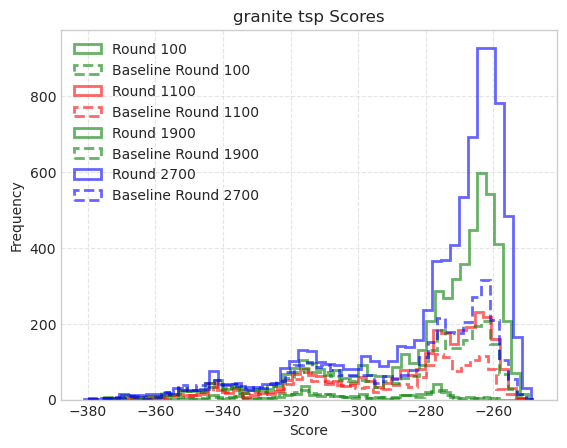

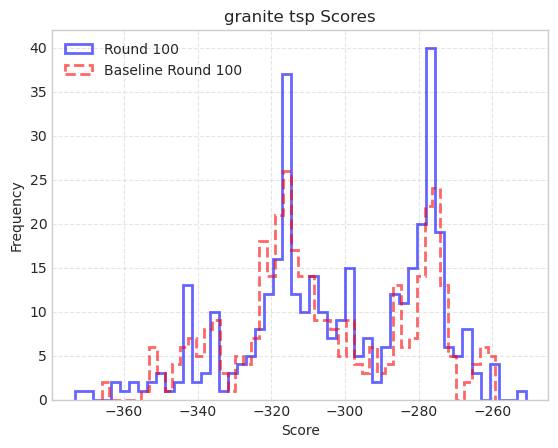

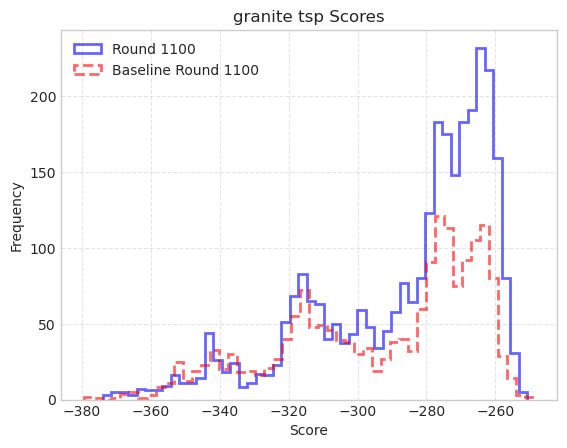

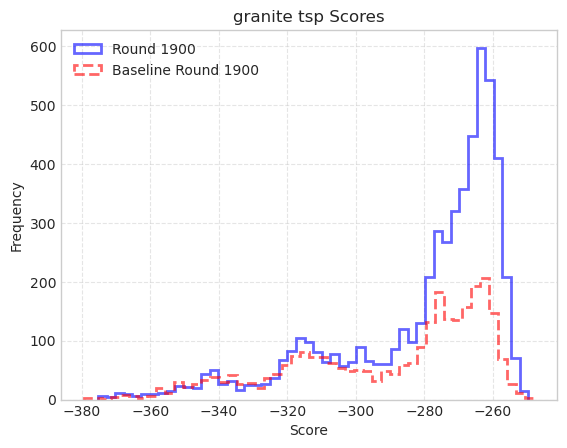

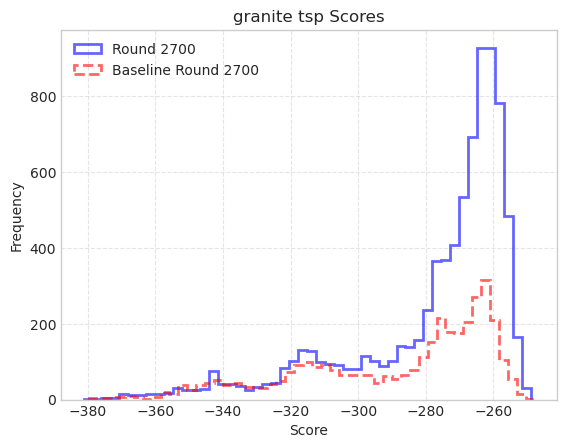

In [94]:
# trained and baseline on the same plot across rounds
model_name = "granite"
seed = 8
sweep_identifier = "s2" # "b"
path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"

with open(path) as f:
    pdb_scores = json.load(f)

scores = {}
for pair in pdb_scores:
    round_num, scores_ = pair.values()
    scores_ = [s for s in scores_ if s > -1000]
    scores[round_num] = np.array(scores_)

sweep_identifier = "b"
path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"

with open(path) as f:
    pdb_scores = json.load(f)

scores_baseline = {}
for pair in pdb_scores:
    round_num, scores_ = pair.values()
    scores_ = [s for s in scores_ if s > -1000]
    scores_baseline[round_num] = np.array(scores_)


# plot the histograms of the scores across the rounds on the same plot, plot every 1000 rounds and on the same plot, use different colors for each round
round_list = [100, 1100, 1900, 2700]
colors = ["red", "blue", "green"]
rounds = list(scores.keys())
rounds.sort()
rounds = rounds[:max_round_num]
for i, round_num in enumerate(rounds):
    if round_num not in round_list:
        continue
    scores_ = scores[round_num]
    plt.hist(scores_, bins=50, alpha=0.6, label=f"Round {round_num}",
             histtype="step", linewidth=2, color=colors[i % len(colors)])
    scores_baseline_ = scores_baseline[round_num]
    # plt.hist(scores_baseline_, bins=50, alpha=0.6, label=f"Baseline Round {round_num}", 
    plt.hist(scores_baseline_, bins=50, alpha=0.6, label=f"Baseline Round {round_num}",
             histtype="step", linewidth=2, color=colors[i % len(colors)], linestyle="dashed")
    # plt.xlim(-500, -200)


plt.legend()
plt.title(f"{model_name} {task} Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.5)  # Add a subtle grid
plt.show()

# now plot for every round in a separate plot
for round_num in rounds:
    if round_num not in round_list:
        continue
    scores_ = scores[round_num]
    plt.hist(scores_, bins=50, alpha=0.6, label=f"Round {round_num}",
             histtype="step", linewidth=2, color="blue")
    scores_baseline_ = scores_baseline[round_num]
    # plt.hist(scores_baseline_, bins=50, alpha=0.6, label=f"Baseline Round {round_num}", 
    plt.hist(scores_baseline_, bins=50, alpha=0.6, label=f"Baseline Round {round_num}",
             histtype="step", linewidth=2, color="red", linestyle="dashed")
    # plt.xlim(-500, -200)

    plt.legend()
    plt.title(f"{model_name} {task} Scores")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.5)  # Add a subtle grid
    plt.show()

### Step Histogram (EvoTune vs. Funsearch) - on the same plot across rounds, averaged across seeds

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


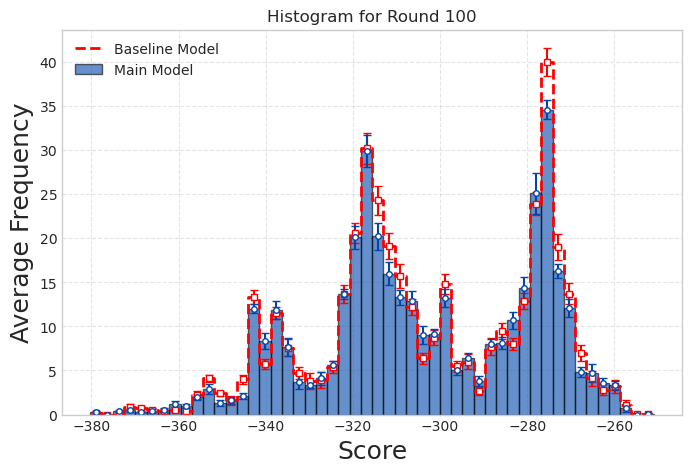

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


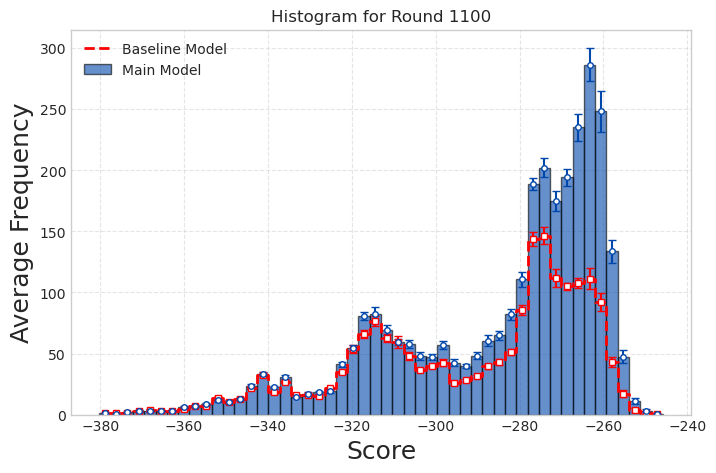

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


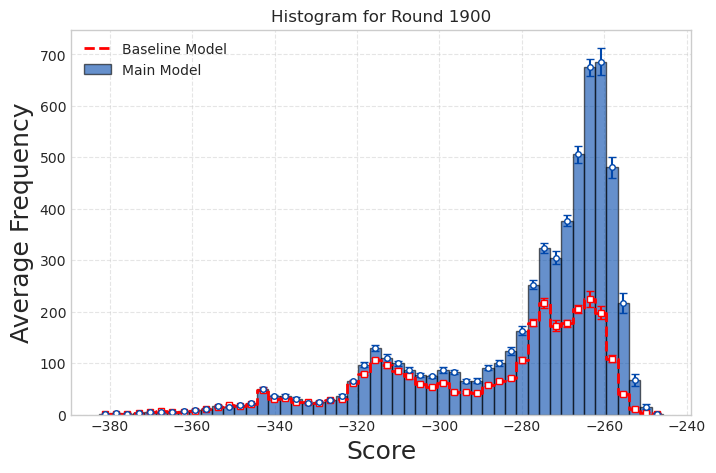

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.


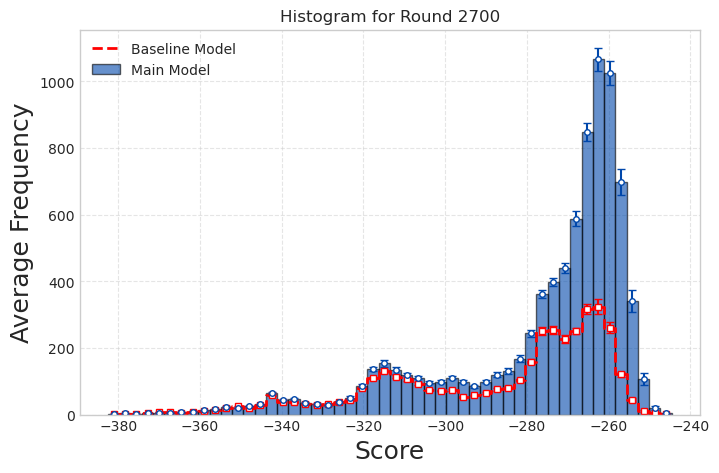

In [135]:
# trained and baseline on the same plot across rounds, averaged across seeds
font_ticks = 18
font_axis = 18

task = "tsp"
model_name = "granite"
sweep_identifier = "s2" # "b"

scores = {}
for seed in range(10):
    scores[seed] = {}
    path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"
    with open(path) as f:
        pdb_scores = json.load(f)
    for pair in pdb_scores:
        round_num, scores_ = pair.values()
        scores_ = [s for s in scores_ if s > -1000]
        scores[seed][round_num] = np.array(scores_)

sweep_identifier = "b"

scores_baseline = {}
for seed in range(10):
    scores_baseline[seed] = {}
    path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"
    with open(path) as f:
        pdb_scores = json.load(f)
    for pair in pdb_scores:
        round_num, scores_ = pair.values()
        scores_ = [s for s in scores_ if s > -1000]
        scores_baseline[seed][round_num] = np.array(scores_)

num_bins = 50
for round_num in [100, 1100, 1900, 2700]:
    all_seeds_scores_main = [scores[seed][round_num] for seed in scores if round_num in scores[seed]]
    all_seeds_scores_baseline = [scores_baseline[seed][round_num] for seed in scores_baseline if round_num in scores_baseline[seed]]

    # Get min/max score range across all seeds
    # all_scores_flat = np.concatenate(all_seeds_scores)
    all_scores_flat = np.concatenate(all_seeds_scores_main + all_seeds_scores_baseline)
    min_score, max_score = np.min(all_scores_flat), np.max(all_scores_flat)


    # Define bin edges
    bins = np.linspace(min_score, max_score, num_bins + 1)

    # Compute histogram counts for each seed in both datasets
    histograms_main = np.array([np.histogram(seed_scores, bins=bins)[0] for seed_scores in all_seeds_scores_main])
    histograms_baseline = np.array([np.histogram(seed_scores, bins=bins)[0] for seed_scores in all_seeds_scores_baseline])

    # Compute mean and stderr of frequencies
    mean_freq_main = np.mean(histograms_main, axis=0)
    stderr_freq_main = np.std(histograms_main, axis=0) / np.sqrt(len(all_seeds_scores_main))

    mean_freq_baseline = np.mean(histograms_baseline, axis=0)
    stderr_freq_baseline = np.std(histograms_baseline, axis=0) / np.sqrt(len(all_seeds_scores_baseline))

    # Plot
    bin_centers = (bins[:-1] + bins[1:]) / 2  # Compute bin centers for plotting
    plt.figure(figsize=(8, 5))

    # # Main model histogram
    # plt.bar(bin_centers, mean_freq_main, width=(bins[1] - bins[0]), color='blue', alpha=0.6, label="Main Model")
    # plt.errorbar(bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o', color='black', capsize=3)

    # # Baseline model histogram (dashed step plot for clarity)
    # plt.step(bin_centers, mean_freq_baseline, where='mid', color='red', linestyle='dashed', linewidth=2, label="Baseline Model")
    # plt.fill_between(bin_centers, mean_freq_baseline - stderr_freq_baseline, mean_freq_baseline + stderr_freq_baseline, 
    #                     color='red', alpha=0.3, step='mid')
    # Main model histogram
    # plt.bar(bin_centers, mean_freq_main, width=(bins[1] - bins[0]), 
    #         color='#4C72B0', alpha=0.5, edgecolor='black', label="Main Model")
    # plt.errorbar(bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o', 
    #             color='#1F4E79', capsize=3, markersize=4)

    # # Baseline model histogram (dashed step plot)
    # plt.step(bin_centers, mean_freq_baseline, where='mid', 
    #         color='#C44E52', linestyle='dashed', linewidth=2, label="Baseline Model")
    # plt.fill_between(bin_centers, mean_freq_baseline - stderr_freq_baseline, 
    #                 mean_freq_baseline + stderr_freq_baseline, 
    #                 color='#C44E52', alpha=0.3, step='mid')



    # Baseline model as step plot
    plt.step(bin_centers, mean_freq_baseline, where='mid',
            color=baseline_color, linestyle='dashed', linewidth=2, label="Baseline Model")
    plt.errorbar(bin_centers, mean_freq_baseline, yerr=stderr_freq_baseline, fmt='s',
                color=baseline_color, capsize=3, markersize=4, markerfacecolor='white')

    # Main model histogram
    plt.bar(bin_centers, mean_freq_main, width=(bins[1] - bins[0]),
            color=main_color, alpha=0.6, edgecolor='black', label="Main Model")
    plt.errorbar(bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o',
                color=main_color, capsize=3, markersize=4, markerfacecolor='white')



    # Labels and legend
    plt.xlabel("Score", fontsize=font_axis, fontfamily=font_family)
    plt.ylabel("Average Frequency", fontsize=font_axis, fontfamily=font_family)

    plt.title(f"Histogram for Round {round_num}")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

# plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
# plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")


### Step Histogram one model - across rounds, using shades

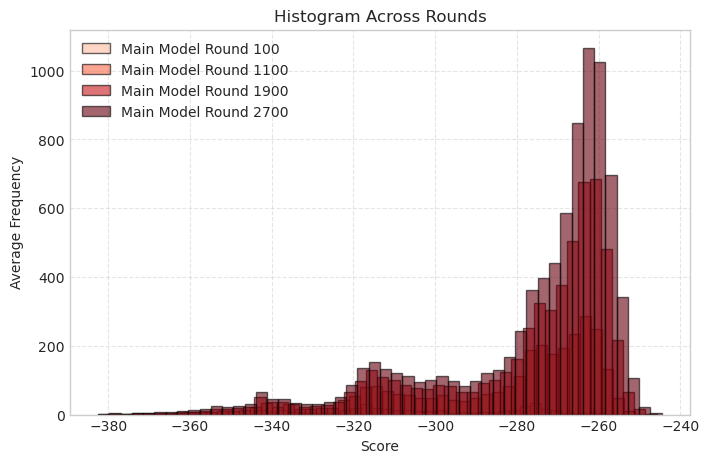

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

rounds = [100, 1100, 1900, 2700]
num_rounds = len(rounds)

# Define color maps
main_cmap = cm.Reds # cm.Blues  # Shades of blue for main model
baseline_cmap = cm.Reds    # Shades of red for baseline

plt.figure(figsize=(8, 5))

for i, round_num in enumerate(rounds):
    all_seeds_scores_main = [scores[seed][round_num] for seed in scores if round_num in scores[seed]]
    all_seeds_scores_baseline = [scores_baseline[seed][round_num] for seed in scores_baseline if round_num in scores_baseline[seed]]

    # Get min/max score range across all seeds
    all_scores_flat = np.concatenate(all_seeds_scores_main + all_seeds_scores_baseline)
    min_score, max_score = np.min(all_scores_flat), np.max(all_scores_flat)

    # Define bin edges
    bins = np.linspace(min_score, max_score, 50 + 1)

    # Compute histogram counts for each seed in both datasets
    histograms_main = np.array([np.histogram(seed_scores, bins=bins)[0] for seed_scores in all_seeds_scores_main])
    histograms_baseline = np.array([np.histogram(seed_scores, bins=bins)[0] for seed_scores in all_seeds_scores_baseline])

    # Compute mean and stderr of frequencies
    mean_freq_main = np.mean(histograms_main, axis=0)
    stderr_freq_main = np.std(histograms_main, axis=0) / np.sqrt(len(all_seeds_scores_main))

    mean_freq_baseline = np.mean(histograms_baseline, axis=0)
    stderr_freq_baseline = np.std(histograms_baseline, axis=0) / np.sqrt(len(all_seeds_scores_baseline))

    # Compute bin centers
    bin_centers = (bins[:-1] + bins[1:]) / 2

    # Select colors based on round order
    main_color = main_cmap((i + 1) / num_rounds)
    baseline_color = baseline_cmap((i + 1) / num_rounds)

    # Plot baseline model as dashed step plot
    # plt.step(bin_centers, mean_freq_baseline, where='mid', color=baseline_color, 
    #          linestyle='dashed', linewidth=2, label=f"Baseline Round {round_num}")
#     plt.errorbar(bin_centers, mean_freq_baseline, yerr=stderr_freq_baseline, fmt='s',
#                  color=baseline_color, capsize=3, markersize=4, markerfacecolor='white')

    # Plot main model histogram as semi-transparent bars
    plt.bar(bin_centers, mean_freq_main, width=(bins[1] - bins[0]), color=main_color,
            alpha=0.6, edgecolor='black', label=f"Main Model Round {round_num}")
#     plt.errorbar(bin_centers, mean_freq_main, yerr=stderr_freq_main, fmt='o', 
#                  color=main_color, capsize=3, markersize=4, markerfacecolor='white')

# Labels and legend
plt.xlabel("Score")
plt.ylabel("Average Frequency")
plt.title("Histogram Across Rounds")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

### Step Histogram one model - across rounds, using stacks

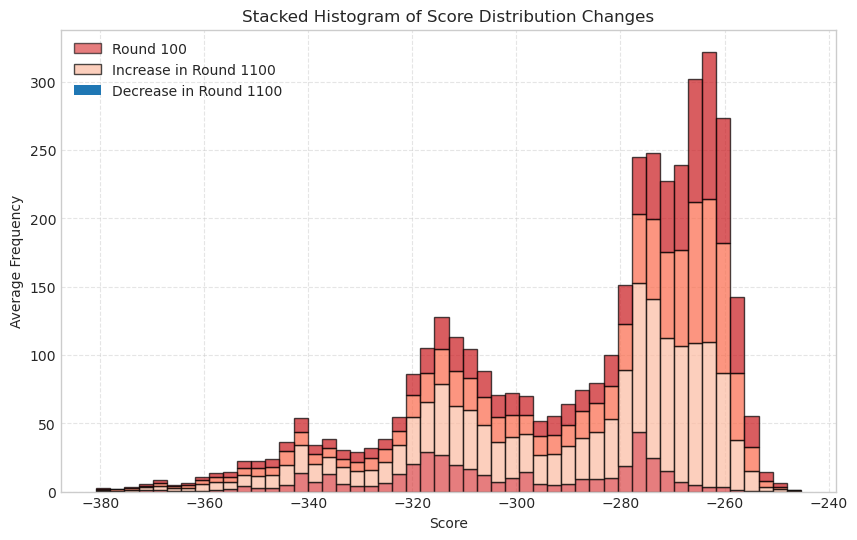

In [100]:
import numpy as np
import matplotlib.pyplot as plt

# Define colors: Base, increases, and decreases
base_color = "#D62728"  # Strong red for the initial histogram
increase_color = cm.Reds # "#FF9999"  # Light red for increases
decrease_color = "#800000"  # Dark red for decreases

rounds_to_plot = [100, 1100, 1900, 2700]
num_bins = 50


scores = {}
for seed in range(10):
    scores[seed] = {}
    path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"
    with open(path) as f:
        pdb_scores = json.load(f)
    for pair in pdb_scores:
        round_num, scores_ = pair.values()
        scores_ = [s for s in scores_ if s > -1000]
        scores[seed][round_num] = np.array(scores_)

sweep_identifier = "b"

scores_baseline = {}
for seed in range(10):
    scores_baseline[seed] = {}
    path = f"/claire-rcp-scratch/shared/packing_logs/logs/sweepfinalicml/{task}_task{task}_{num_models}m{model_name}icml{sweep_identifier}_{seed}/programdb_scores.json"
    with open(path) as f:
        pdb_scores = json.load(f)
    for pair in pdb_scores:
        round_num, scores_ = pair.values()
        scores_ = [s for s in scores_ if s > -1000]
        scores_baseline[seed][round_num] = np.array(scores_)

# Get min/max score range across all rounds
all_scores_flat = np.concatenate([
    scores[seed][rnd] for seed in scores for rnd in rounds_to_plot if rnd in scores[seed]
])
min_score, max_score = np.min(all_scores_flat), np.max(all_scores_flat)

bins = np.linspace(min_score, max_score, num_bins + 1)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Compute histograms for each round
histograms = {
    rnd: np.array([
        np.histogram(scores[seed][rnd], bins=bins)[0]
        for seed in scores if rnd in scores[seed]
    ])
    for rnd in rounds_to_plot
}

# Compute mean and stderr for each round
mean_freq = {rnd: np.mean(histograms[rnd], axis=0) for rnd in rounds_to_plot}
stderr_freq = {rnd: np.std(histograms[rnd], axis=0) / np.sqrt(len(histograms[rnd])) for rnd in rounds_to_plot}

plt.figure(figsize=(10, 6))

# Start with the first round as the base layer
cumulative_freq = np.zeros_like(mean_freq[rounds_to_plot[0]])
plt.bar(bin_centers, mean_freq[rounds_to_plot[0]], width=(bins[1] - bins[0]),
        color=base_color, alpha=0.6, edgecolor='black', label=f"Round {rounds_to_plot[0]}")
cumulative_freq += mean_freq[rounds_to_plot[0]]

# Add stacked changes for each subsequent round
for i in range(len(rounds_to_plot) - 1):
    prev_round = rounds_to_plot[i]
    curr_round = rounds_to_plot[i + 1]

    delta = mean_freq[curr_round] - mean_freq[prev_round]

    # Plot increases as stacked bars
    color_increase = increase_color((i + 1) / len(rounds_to_plot))
    increase_mask = delta > 0
    plt.bar(bin_centers[increase_mask], delta[increase_mask], width=(bins[1] - bins[0]),
            bottom=cumulative_freq[increase_mask], edgecolor='black', color=color_increase, alpha=0.7,
            label=f"Increase in Round {curr_round}" if i == 0 else "")

    # Plot decreases as stacked negative bars
    decrease_mask = delta < 0
    plt.bar(bin_centers[decrease_mask], np.abs(delta[decrease_mask]), width=(bins[1] - bins[0]),
            bottom=cumulative_freq[decrease_mask] + delta[decrease_mask],
            edgecolor='black', color=decrease_color, alpha=0.7, label=f"Decrease in Round {curr_round}" if i == 0 else "")

    # Update cumulative sum for stacking
    cumulative_freq += delta

plt.xlabel("Score")
plt.ylabel("Average Frequency")
plt.title("Stacked Histogram of Score Distribution Changes")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()